# Fish Weight Prediction - A regression implementation

In [1]:
# importing dependencies here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# plot
from scipy import stats

# saving the model
from joblib import dump

# formatting
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# reading the input file
fish_data = pd.read_csv("fish_participant.csv")

<IPython.core.display.Javascript object>

In [3]:
# checking first 5 records
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
1,Perch,110.0,20.0,22.0,23.5,5.5225,3.9950
2,Roach,160.0,20.5,22.5,25.3,7.0334,3.8203
3,Parkki,60.0,14.3,15.5,17.4,6.5772,2.3142
4,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854


<IPython.core.display.Javascript object>

### Exploratory Data Analysis

In [4]:
# checking the data types
fish_data.dtypes

Species     object
Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64
dtype: object

<IPython.core.display.Javascript object>

The data types look okay.

In [5]:
# checking for missing values
fish_data.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

<IPython.core.display.Javascript object>

There is no missing data present.

In [6]:
fish_data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,401.676577,26.447748,28.615315,31.422523,9.015701,4.480407
std,338.510755,9.795155,10.498781,11.306311,4.225369,1.696240
min,5.900000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,142.500000,20.000000,22.000000,23.500000,6.138850,3.551400
50%,300.000000,25.400000,27.500000,30.100000,8.145400,4.335000
75%,682.500000,33.750000,36.250000,40.150000,12.143400,5.658300
max,1550.000000,56.000000,60.000000,64.000000,18.957000,8.142000


<IPython.core.display.Javascript object>

For the target variable "Weight", the difference between the min and max value semms to be significantly large. <br>
There could be some outliers present possibly that I will handle later in this code.

In [7]:
# checking for correlations
corr = fish_data.corr()
corr.style.background_gradient(cmap="ocean")

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.900963,0.904090,0.909553,0.738316,0.893379
Length1,0.900963,1.000000,0.999468,0.991363,0.621648,0.862612
Length2,0.904090,0.999468,1.000000,0.993695,0.637353,0.869217
Length3,0.909553,0.991363,0.993695,1.000000,0.702567,0.872672
Height,0.738316,0.621648,0.637353,0.702567,1.000000,0.782936
Width,0.893379,0.862612,0.869217,0.872672,0.782936,1.000000


<IPython.core.display.Javascript object>

All the features are showing strong correlation with the target vaibale weight.<br>
The 3 Length variables are showing collinearity. I will handle this later in this code.

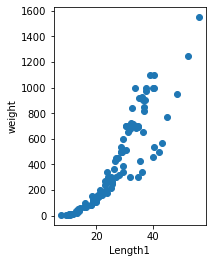

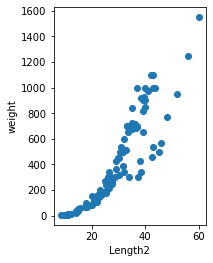

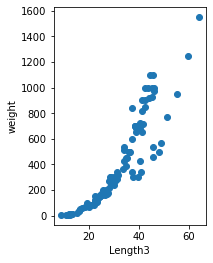

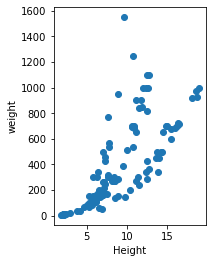

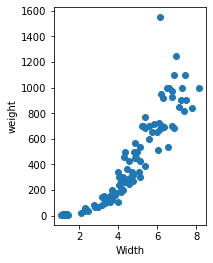

<IPython.core.display.Javascript object>

In [8]:
# checking for linear relationship between features and the target variable

numerical = ["Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:
    plt.subplot(1, 2, 1)
    plt.scatter(x=fish_data[feature], y=fish_data["Weight"])
    plt.xlabel(feature)
    plt.ylabel("weight")
    plt.show()

The relationship between the features and the target variable is not linear. I will be fixing it later in this code.

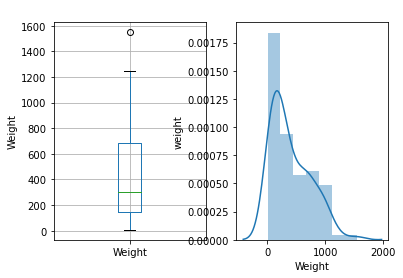

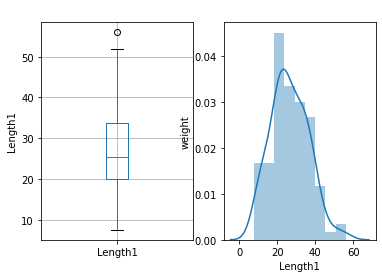

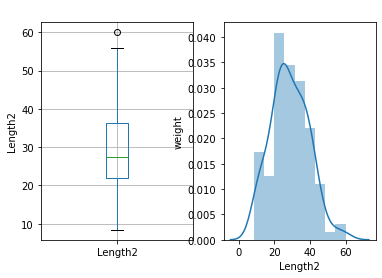

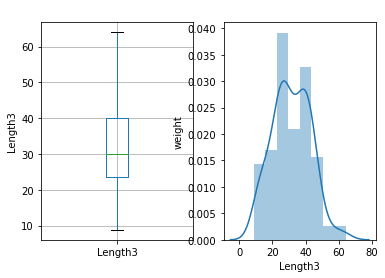

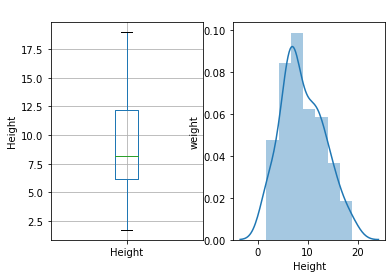

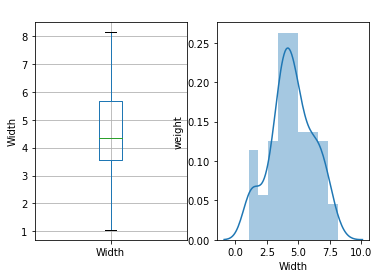

<IPython.core.display.Javascript object>

In [9]:
# checking for outliers and distribution

numerical = ["Weight", "Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:

    plt.subplot(1, 2, 1)
    fig = fish_data.boxplot(column=feature)
    fig.set_title(" ")
    fig.set_ylabel(feature)

    plt.subplot(1, 2, 2)
    fig = sns.distplot(fish_data[feature])
    fig.set_ylabel("weight")
    fig.set_xlabel(feature)

    plt.show()

There outliers present in target variable "Weight" and features "Lenght1", "Length2". Rest of the data looks good.<br>
The distributions look skewed. 

In [10]:
# finding the outliers

for col in numerical:
    df = fish_data[col]
    df_Q1 = df.quantile(0.25)
    df_Q3 = df.quantile(0.75)
    df_IQR = df_Q3 - df_Q1
    df_lowerend = df_Q1 - (1.5 * df_IQR)
    df_upperend = df_Q3 + (1.5 * df_IQR)

    df_outliers = df[(df < df_lowerend) | (df > df_upperend)]
    print(df_outliers)

13    1550.0
Name: Weight, dtype: float64
13    56.0
Name: Length1, dtype: float64
13    60.0
Name: Length2, dtype: float64
Series([], Name: Length3, dtype: float64)
Series([], Name: Height, dtype: float64)
Series([], Name: Width, dtype: float64)


<IPython.core.display.Javascript object>

Record at row # 13 seems to be the outlier for weight, lenght1 and length2. <br>
Dropping this record from the dataset.

In [11]:
# dropping the outlier at row # 13
fish_data = fish_data.drop([13])

<IPython.core.display.Javascript object>

In [12]:
# applying log conversion to normalizes the distribution of features and the target variable to some extent
fish_data["Weight"] = np.log(fish_data["Weight"])
fish_data["Length1"] = np.log(fish_data["Length1"])
fish_data["Length2"] = np.log(fish_data["Length2"])
fish_data["Length3"] = np.log(fish_data["Length3"])
fish_data["Height"] = np.log(fish_data["Height"])
fish_data["Width"] = np.log(fish_data["Width"])

<IPython.core.display.Javascript object>

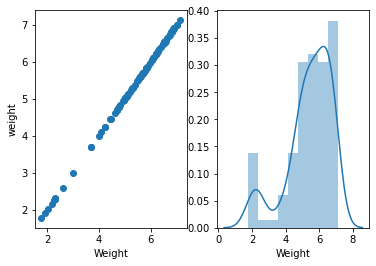

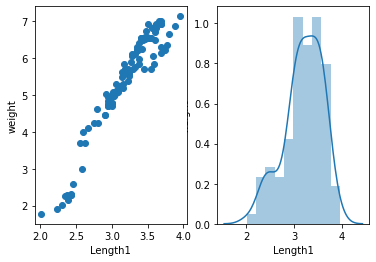

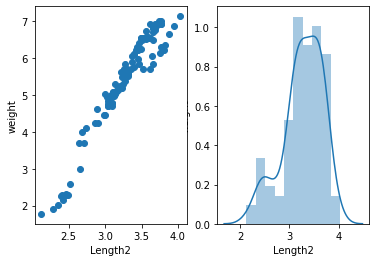

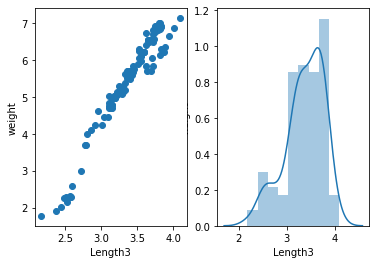

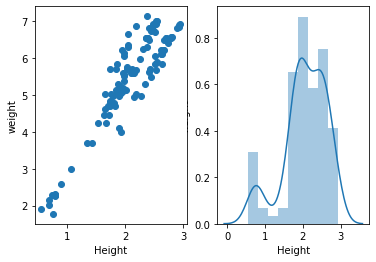

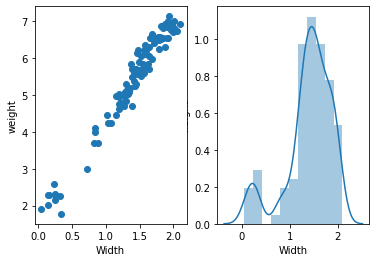

<IPython.core.display.Javascript object>

In [13]:
# rechecking the linear relationships and distributions

numerical = ["Weight", "Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:

    plt.subplot(1, 2, 2)
    fig = sns.distplot(fish_data[feature])
    fig.set_ylabel("weight")
    fig.set_xlabel(feature)

    plt.subplot(1, 2, 1)
    plt.scatter(x=fish_data[feature], y=fish_data["Weight"])
    plt.xlabel(feature)
    plt.ylabel("weight")
    plt.show()

    plt.show()

The linear relationship between the features and the target variable looks better now. <br>
The distributions are still a little skewed but for now we will move ahead with this. 

Perch        39
Bream        24
Roach        14
Pike         11
Smelt        10
Parkki        8
Whitefish     4
Name: Species, dtype: int64


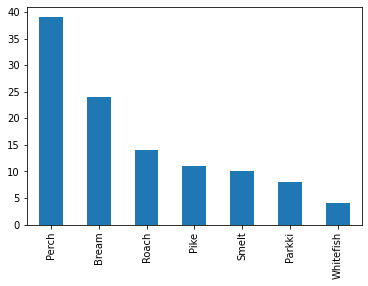

<IPython.core.display.Javascript object>

In [14]:
# checking the categorical feature - Species
print(fish_data["Species"].value_counts())
fish_data["Species"].value_counts().plot(kind="bar")
plt.show()

This catgorical feature will need encoding. I will handle this using OneHotEncoder later in this code. 

In [15]:
# checking for collinerity between the 3 length variables
fish_data[["Length1", "Length2", "Length3"]].corr()

,Length1,Length2,Length3
Length1,1.000000,0.999338,0.994402
Length2,0.999338,1.000000,0.995762
Length3,0.994402,0.995762,1.000000


<IPython.core.display.Javascript object>

The 3 lenght variables are highly correlated. Let's check their values.

In [16]:
fish_data[["Length1", "Length2", "Length3"]].head(10)

,Length1,Length2,Length3
0,3.277145,3.367296,3.526361
1,2.995732,3.091042,3.157000
2,3.020425,3.113515,3.230804
3,2.660260,2.740840,2.856470
4,3.414443,3.496508,3.645450
5,2.624669,2.708050,2.772589
6,3.414443,3.496508,3.650658
7,3.234749,3.314186,3.363842
8,2.230014,2.282382,2.379546
9,3.144152,3.234749,3.401197


<IPython.core.display.Javascript object>

Since Length3 values are the highest for each row, it is probably the Total Length of the fish. <br>
So keeping Length3 and dropping the other two length variables from the dataset. 

In [17]:
fish_data = fish_data.drop(["Length1", "Length2"], axis=1)

<IPython.core.display.Javascript object>

### Model Creation

In [18]:
# dividing the data into features and target variable
X = fish_data.drop("Weight", axis=1)
y = fish_data["Weight"]

<IPython.core.display.Javascript object>

In [19]:
# encoding the categorical feature - species
ct = ColumnTransformer(
    [("one_hot_encoder", OneHotEncoder(categories="auto"), [0])],
    remainder="passthrough",
)

X = ct.fit_transform(X)

<IPython.core.display.Javascript object>

In [20]:
# splitting the data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

<IPython.core.display.Javascript object>

### Linear Regression

In [21]:
# building pipeline for Linear Regression
pipe = make_pipeline(StandardScaler(), LinearRegression())

# fitting the data
pipe.fit(X_train, y_train)

# predicting
y_predict = pipe.predict(X_test)

<IPython.core.display.Javascript object>

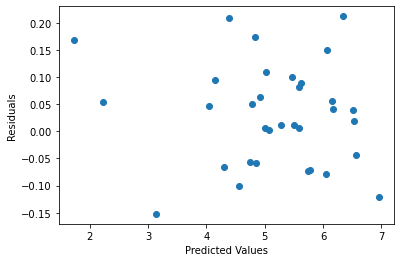

<IPython.core.display.Javascript object>

In [22]:
# Residual Plot
plt.scatter(y_predict, y_test - y_predict)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

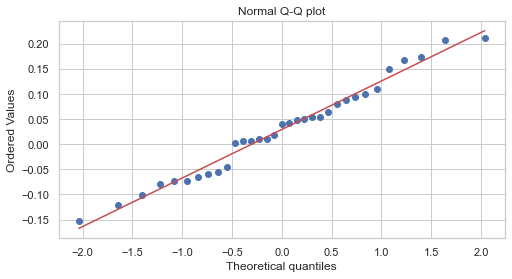

<IPython.core.display.Javascript object>

In [23]:
# Normal Q-Q plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
stats.probplot(y_test - y_predict, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

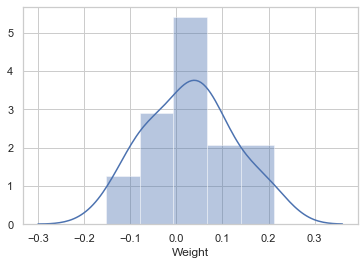

<IPython.core.display.Javascript object>

In [24]:
# distplot
sns.distplot(y_test - y_predict)

In [25]:
# Test MSE and R2
print(f"\nLinear Regression Test MSE: {mean_squared_error(y_test, y_predict)}")
print(f"Linear Regression Test Accuracy (R-Squared): {r2_score(y_test, y_predict)}")


Linear Regression Test MSE: 0.009432470007646266
Linear Regression Test Accuracy (R-Squared): 0.9929005201021582


<IPython.core.display.Javascript object>

In [26]:
# cross validation score
cv_score = np.mean(
    (cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_squared_error")) * -1
)
print(f"\nLinear Regression Cross Validation Score: {cv_score}")


Linear Regression Cross Validation Score: 0.009967670222495945


<IPython.core.display.Javascript object>

### Lasso

In [27]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

# building lasso pipeline
lasso_pipe = make_pipeline(StandardScaler(), Lasso())

parameters = {
    "lasso__alpha": [1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40]
}

lasso_regressor = GridSearchCV(
    lasso_pipe, parameters, scoring="neg_mean_squared_error", cv=5
)

lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
       

<IPython.core.display.Javascript object>

In [28]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
prediction_lasso = lasso_regressor.predict(X_test)

{'lasso__alpha': 0.001}
-0.009616628242632945


<IPython.core.display.Javascript object>

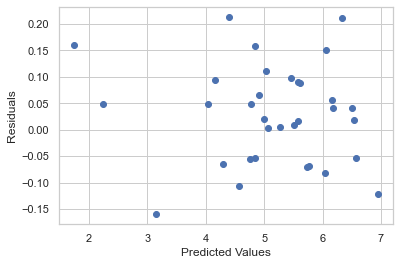

<IPython.core.display.Javascript object>

In [29]:
# Lasso Residual Plot
plt.scatter(prediction_lasso, y_test - prediction_lasso)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

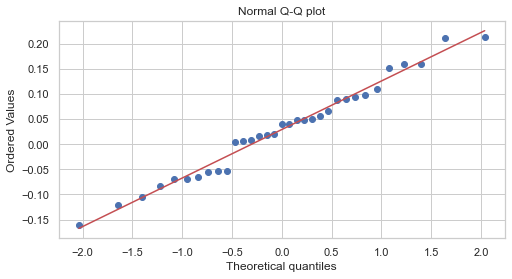

<IPython.core.display.Javascript object>

In [30]:
# Lasso Normal Q-Q plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
stats.probplot(y_test - prediction_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

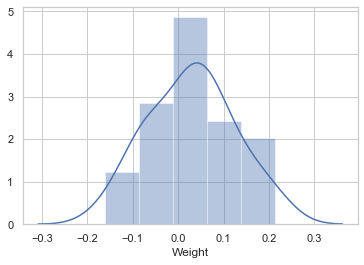

<IPython.core.display.Javascript object>

In [31]:
# distplot
sns.distplot(y_test - prediction_lasso)

In [32]:
# MSE for test data
print("Lasso Test MSE:", mean_squared_error(y_test, prediction_lasso))

# R2 for test data
print(
    "\nLasso Test Accuracy (R-Squared):", r2_score(y_test, prediction_lasso),
)

# cross validation score
cv_score = np.mean(
    (cross_val_score(lasso_regressor, X, y, cv=5, scoring="neg_mean_squared_error"))
    * -1
)
print("\nLasso Cross Validation Score:", cv_score)

Lasso Test MSE: 0.00939718180990728

Lasso Test Accuracy (R-Squared): 0.9929270802555725

Lasso Cross Validation Score: 0.009857483870101994


<IPython.core.display.Javascript object>

### Random Forest

In [33]:
rf = RandomForestRegressor(n_estimators=100)

# fitting the data
rf.fit(X_train, y_train)

# predicting
rf_predictions = rf.predict(X_test)

<IPython.core.display.Javascript object>

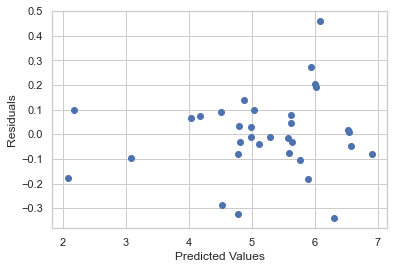

<IPython.core.display.Javascript object>

In [34]:
# Random Forest Residual Plot
plt.scatter(rf_predictions, y_test - rf_predictions)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

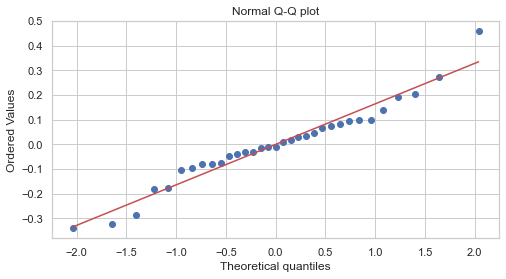

<IPython.core.display.Javascript object>

In [35]:
# Random Forest Normal Q-Q plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))
stats.probplot(y_test - rf_predictions, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [36]:
# test MSE
print(f"Random Forest Test MSE: {mean_squared_error(y_test, rf_predictions)}")

# test R2
print(f"Random Forest Test Accuracy: {rf.score(X_test, y_test)}")

# cross validation score
cv_score = np.mean(
    (cross_val_score(rf, X, y, cv=5, scoring="neg_mean_squared_error")) * -1
)
print(f"Random Forest Cross Validation Score: {cv_score}")

Random Forest Test MSE: 0.025617448824574368
Random Forest Test Accuracy: 0.9807186704207248
Random Forest Cross Validation Score: 0.024767059770408398


<IPython.core.display.Javascript object>

Random Forest didn't do very well for this dataset as compared to the Linear and Lasso Models. 

### Selecting Lasso as the final model for this dataset as it gave the lowest CV MSE.  

In [37]:
# retraining the Lasso Model with best paramater value and entire dataset

# building lasso pipeline
lasso_pipe = make_pipeline(StandardScaler(), Lasso())

parameters = {"lasso__alpha": [0.001]}

lasso_regressor = GridSearchCV(
    lasso_pipe, parameters, scoring="neg_mean_squared_error", cv=5
)

lasso_regressor.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
       

<IPython.core.display.Javascript object>

In [38]:
# MSE for test data
print("Lasso Test MSE:", mean_squared_error(y_test, prediction_lasso))

# R2 for test data
print(
    "Lasso Test Accuracy (R-Squared):", r2_score(y_test, prediction_lasso),
)

# cross validation score
cv_score = np.mean(
    (cross_val_score(lasso_regressor, X, y, cv=5, scoring="neg_mean_squared_error"))
    * -1
)
print("Lasso Cross Validation Score:", cv_score)

Lasso Test MSE: 0.00939718180990728
Lasso Test Accuracy (R-Squared): 0.9929270802555725
Lasso Cross Validation Score: 0.009799837614077551


<IPython.core.display.Javascript object>

### Saving the final model

In [39]:
dump(lasso_regressor, "reg.joblib")

['reg.joblib']

<IPython.core.display.Javascript object>